# Covid Case Prediction Using Deep Learning

**Objective:** Given survey results in the past 3 days in a specific state in U.S., predict the percentage of new tested positive cases in the 3rd day.

This notebook is divided into the following sections:

1. Data Exploration
2. Data Preparation
3. Data Modeling
4. Empirical Results and Evaluation

## Data Exploration

Performing some preliminary data analysis.

In [37]:
import pandas as pd
import numpy as np

In [41]:
# Loading the datasets
train_df = pd.read_csv('covid.train.csv')
test_df = pd.read_csv('covid.test.csv')

train_df.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [42]:
# Printing columns of the dataset
# Test df should contain all same columns as train df except the target column
assert set(train_df.columns) == set(test_df.columns) | {'tested_positive.2'}
print(train_df.columns)

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

**Dataset Attributes**

Here, we see how this dataset is structured. Since it is a survey data, it includes the the answers of some questions, such as whether or not the surveyer was wearing a mask, using public transport, traveled out of state, etc., as well as the state of residence.

All columns have been one hot encoded (specifically for state), meaning we don't have to do a lot of preprocessing. As a safety measure, we will drop any rows with missing values.

In [43]:
# Dropping the rows with missing values and duplicates
train_df = train_df.dropna()
test_df = test_df.dropna()

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [44]:
# Some visualization

# We will check the distribution of survey answers by state
import matplotlib.pyplot as plt

# Getting columns that we need (indexes 1 to 50)
state_columns = train_df.columns[1:41]
state_columns

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI'],
      dtype='object')

We see that some states are missing (only 40 states included in the survey), but we will continue

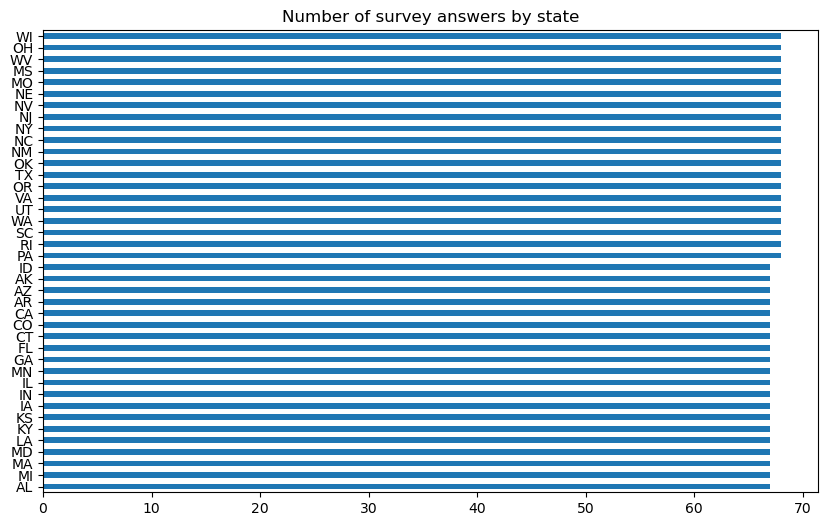

In [45]:
# Visualizing the number of survey answers for each state
plt.figure(figsize=(10, 6))
train_df[state_columns].sum().sort_values().plot(kind='barh')
plt.title('Number of survey answers by state')
plt.show()

We see that each state included in the survey is adequately represented. 

Now, a correlation matrix of features.

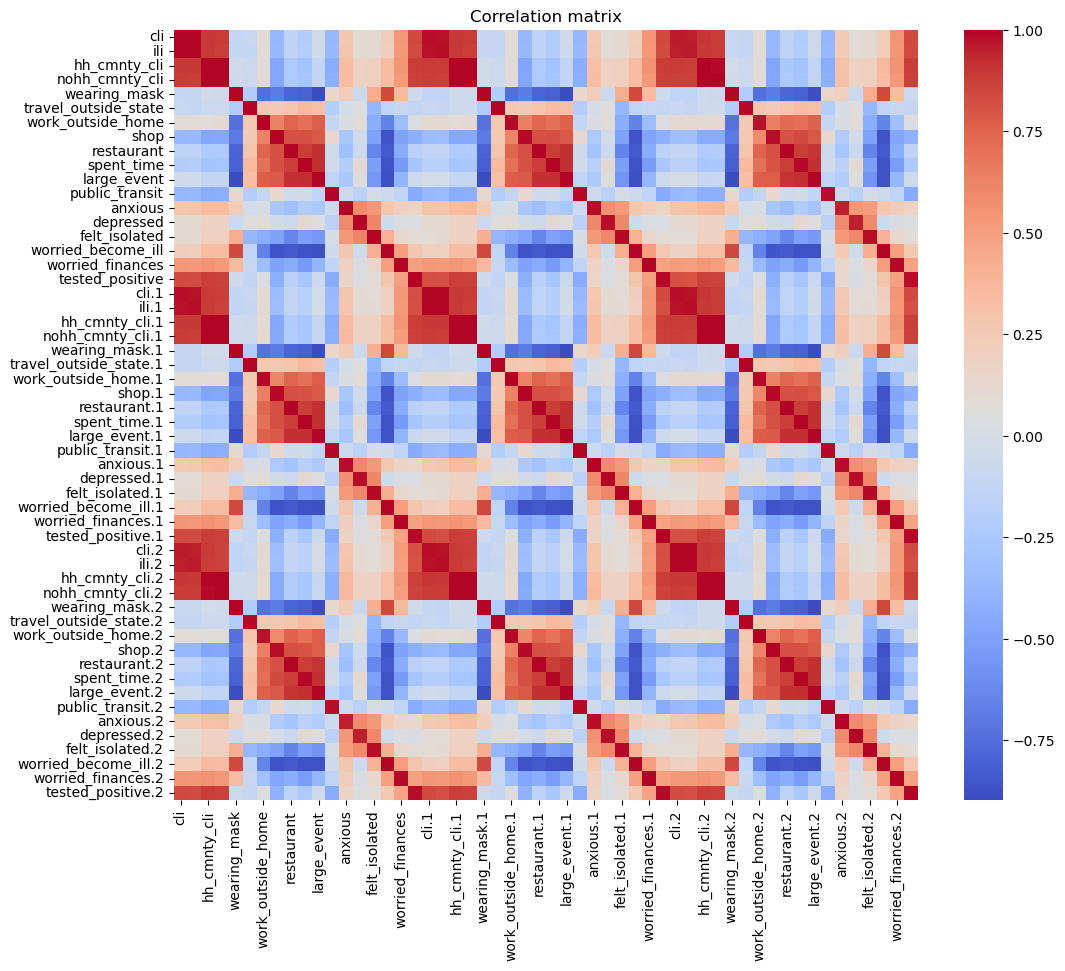

In [52]:
# Correlation matrix of features (minus the state columns)
import seaborn as sns

features = train_df.columns[41:]
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[features].corr(), cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Heatmap interpretation:

1. Features seperated by day (day 0, day 1, day 2)
2. Strong correlation between day 0, day 1, day 2 features (i.e., wearing_mask, wearing_mask.1, wearing_mask.2). Makes sense in the context of the dataset since we are trying to predict positivite rate on 3rd day
3. Noticable correlation variance between features are target variable (test_positive)

These findings help us better understand the dataset. Moving onto data preparation using PyTorch.

## Data Preparation

In order to train our model, the data must be converted to tensors. Pytorch has built in classes to conveniently handle datasets

**Dataset** stores the samples and their corresponding labels

**DataLoader** wraps an iterable around the Dataset to enable easy access to samples

*from PyTorch docs*

In [55]:
# Importing PyTorch DataSet and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

In [56]:
'''
Creating custom dataset for the Covid Data, includes the following methods:

__init__:       Initializes the dataset. 
                Takes features and labels as input as torch tensors

__len__:        Returns the length of the dataset

__getitem__:    Returns a sample from the dataset given an index

This is necessary to use DataLoader, which is crucial for training the model
'''
class CovidDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Retrieving features and labels for a given index
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

In [57]:
# Converting the data to PyTorch tensors
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_df.iloc[:, -1].values, dtype=torch.float32)

X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)
y_test = torch.tensor(test_df.iloc[:, -1].values, dtype=torch.float32)

# Creating dataset instances
train_dataset = CovidDataset(X_train, y_train)
test_dataset = CovidDataset(X_test, y_test)

In [60]:
train_dataset.__getitem__(50)

(tensor([50.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.9189,  0.9334, 28.7825, 23.7822, 82.5657, 14.1361, 36.0480,
         62.9211, 25.4658, 45.5205, 21.1454,  2.2790, 16.5211, 12.6508, 17.1749,
         54.7711, 40.5673, 18.8368,  1.2067,  1.2011, 30.0138, 24.5077, 82.2347,
         13.9277, 36.4484, 63.4678, 25.4995, 45.9818, 22.0025,  2.3522, 17.3755,
         13.3316, 17.7056, 54.4002, 41.2933, 20.8130,  1.1916,  1.1754, 29.5151,
         23.8887, 82.1641, 13.5269, 36.0463, 63.5305, 25.8141, 46.0248, 22.5160,
          2.1776, 17.8999, 13.4763, 17.5778, 54.5751, 41.8184]),
 tensor(20.8325))

**Creating DataLoaders**

The DataLoader class in PyTorch used to retreive the datasets features and labels on sample at a time. During model training, this allows us to pass samples in "minibatches", reshuffle the data each epoch to prevent overfitting, and use Python's multiprocessing for faster data retreival.

DataLoader is an iterable object that we can load our custom dataset into.

Key DataLoader parameters:

1. 'batch_size': defines # of samples returned in per each iteration
2. 'shuffle': data will be shuffled before being passed to the model if true.
            

In [61]:
# Training and test dataLoaders
# Batch size 32, shuffling enabled for training data
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [62]:
for features, labels in train_dataloader:
    print(features.shape, labels.shape)
    break

torch.Size([32, 94]) torch.Size([32])


## Data Modeling

Implement deep NN using Pytorch.

In [3]:
import torch

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Results and Evaluation

In [1]:
import torch

In [2]:
# Testing the GPU
print(torch.cuda.is_available())

True
